### Method: Linear Interpolation with Gaussian Noise Injection

This technique is used to create a new, realistic dataset (Synthetic Data) by combining two existing datasets. It simulates a new "measurement session" that follows the same trends as the original files but is not an exact copy of either.

#### 1. Data Alignment (Synchronization)

Before combining the data, we must ensure both files have the exact same number of data points (rows).

* We perform mathematical operations row-by-row. If File 1 has 1000 rows and File 2 has 1005 rows, the calculation will fail.
* We truncate (cut) both files to the length of the shorter file so they match perfectly.

#### 2. Weighted Linear Interpolation (The "Mixing" Phase)

This is the core concept. We create a "base signal" by mixing the values from File 1 and File 2.

* **The Parameter:** We use a variable called **Alpha ()** as a mixing slider.
* **The Logic:**
* If : The new value is exactly in the middle (50% File 1, 50% File 2).
* If : The new value is 80% similar to File 1 and 20% similar to File 2.


* **The Formula:**

$Value_{mix} = (\alpha \times Value_{File1}) + ((1 - \alpha) \times Value_{File2})$

#### 3. Gaussian Noise Injection (The "Realism" Phase)

If we only did step 2, the resulting data would look too "smooth" and artificial. Real sensor data always has slight fluctuations (electronic noise, environmental jitter).

* **The Action:** We add a small random value to every data point.
* **The Math:** We use a **Normal Distribution (Gaussian Distribution)** centered at 0.
* **Scaling:** We don't just add *any* random number. We calculate the **Standard Deviation ()** of the current signal to know how much the data typically fluctuates. The noise we add is a percentage of that fluctuation (controlled by the `NOISE_LEVEL` variable).

#### Summary of Parameters

| Parameter | Code Variable | Description |
| --- | --- | --- |
| **Mixing Factor** | `ALPHA` | Controls the balance. Closer to 1.0 looks like File 1; closer to 0.0 looks like File 2. |
| **Noise Level** | `NOISE_LEVEL` | Controls the "roughness." A value of `0.05` means we add noise equivalent to 5% of the signal's standard deviation. |

#### Why is this method effective?

1. **Physical Validity:** Since the new data is derived from real measurements, it respects the physical limits and general behavior of your sensors (it won't generate impossible values like -500V).
2. **Uniqueness:** Because of the random noise, the generated file is statistically unique. It will never be identical to the original files, which is excellent for testing algorithms or training AI models.

Loading files:
 - measurement_normalized_selective_rounded_1.csv
 - measurement_normalized_selective_rounded_2.csv
Aligning data length to 7931 rows...
Generating synthetic data with Alpha=0.6 and Noise Level=0.05...

[SUCCESS] Synthetic data saved to: synthetic_data_generated.csv
Total rows: 7931


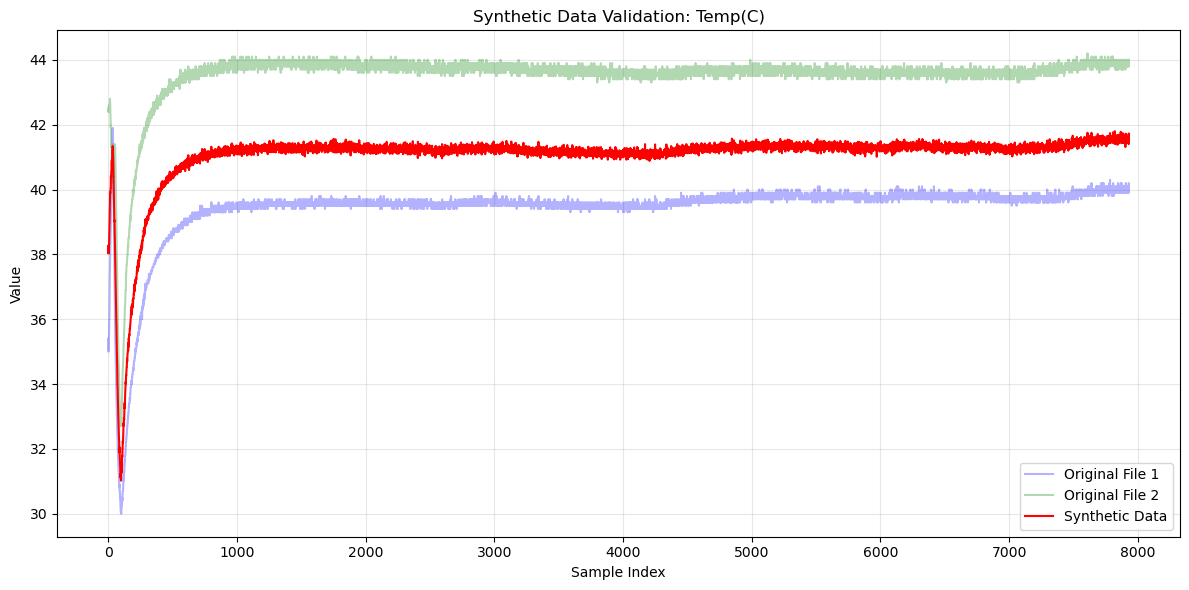

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# =========================================================
# CONFIGURATION
# =========================================================
file_path_1 = "measurement_normalized_selective_rounded_1.csv"
file_path_2 = "measurement_normalized_selective_rounded_2.csv"
output_path = "synthetic_data_generated.csv"

# Mixing Factor (Alpha):
# 0.5 means equal contribution from both files.
# 0.7 means 70% from File 1 and 30% from File 2.
ALPHA = 0.6 

# Noise Level:
# 0.05 means the added noise magnitude is 5% of the data's standard deviation.
NOISE_LEVEL = 0.05 

# =========================================================
# MAIN SCRIPT
# =========================================================

def generate_synthetic_data():
    # 1. Load Data
    # Check if input files exist to avoid runtime errors
    if not os.path.exists(file_path_1) or not os.path.exists(file_path_2):
        print(f"Error: Input files not found.")
        return

    print(f"Loading files:\n - {file_path_1}\n - {file_path_2}")
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)

    # 2. Synchronize Lengths
    # To perform vector operations, both dataframes must have the same number of rows.
    # We truncate both files to the length of the shorter file.
    min_len = min(len(df1), len(df2))
    
    print(f"Aligning data length to {min_len} rows...")
    df1 = df1.iloc[:min_len].reset_index(drop=True)
    df2 = df2.iloc[:min_len].reset_index(drop=True)

    # 3. Create Synthetic DataFrame
    # Start by copying df1 structure
    df_synthetic = df1.copy()

    # Identify numeric columns (Sensors, Temp, Hum) used for calculation
    numeric_cols = df1.select_dtypes(include=['float64', 'int64']).columns.tolist()

    print(f"Generating synthetic data with Alpha={ALPHA} and Noise Level={NOISE_LEVEL}...")

    for col in numeric_cols:
        # Step 3a: Linear Interpolation (Weighted Average)
        # Mix values from both files based on the ALPHA factor
        val1 = df1[col]
        val2 = df2[col]
        mixed_signal = (ALPHA * val1) + ((1 - ALPHA) * val2)

        # Step 3b: Noise Injection
        # Calculate standard deviation of the mixed signal to scale the noise appropriately
        std_dev = mixed_signal.std()
        
        # Generate Gaussian noise (mean=0, std=std_dev * noise_level)
        noise = np.random.normal(loc=0, scale=std_dev * NOISE_LEVEL, size=min_len)

        # Step 3c: Final Combination
        df_synthetic[col] = mixed_signal + noise

    # 4. Final Polish
    # Keep the Timestamp from the primary file (df1) to maintain time continuity
    if 'Timestamp' in df1.columns:
        df_synthetic['Timestamp'] = df1['Timestamp']

    # Round all numeric values to 2 decimal places as requested
    df_synthetic = df_synthetic.round(2)

    # 5. Export to CSV
    df_synthetic.to_csv(output_path, index=False)
    print(f"\n[SUCCESS] Synthetic data saved to: {output_path}")
    print(f"Total rows: {len(df_synthetic)}")

    # =========================================================
    # VISUALIZATION (VALIDATION)
    # =========================================================
    # Plotting one sensor to visually compare Original vs Synthetic
    if len(numeric_cols) > 0:
        target_col = numeric_cols[0] # Pick the first numeric column (e.g., MQ2)
        
        plt.figure(figsize=(12, 6))
        
        # Plot Original File 1
        plt.plot(df1.index, df1[target_col], label='Original File 1', color='blue', alpha=0.3)
        
        # Plot Original File 2
        plt.plot(df2.index, df2[target_col], label='Original File 2', color='green', alpha=0.3)
        
        # Plot Synthetic Data (Should be in between but distinct)
        plt.plot(df_synthetic.index, df_synthetic[target_col], 
                 label='Synthetic Data', color='red', linewidth=1.5, linestyle='-')

        plt.title(f"Synthetic Data Validation: {target_col}")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Run the function
if __name__ == "__main__":
    generate_synthetic_data()